# HFT Strategy Simulator - Analysis & Visualization

This notebook provides comprehensive visualization of ping-pong strategy simulation results.
Run a simulation first, then use these plots to analyze performance.

In [2]:
# Setup and Imports
import sys
sys.path.insert(0, "../build")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import orderbook_wrapper as sim
from strategies import STRATEGIES, BALANCED, AGGRESSIVE, PASSIVE, DEFAULT_SIM_CONFIG
from run_experiment import run_simulation, print_summary

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ Setup complete")

ModuleNotFoundError: No module named 'orderbook_wrapper'

## 1. Run Simulation

Configure and run a simulation to generate data for plotting.

In [ ]:
# === CONFIGURATION ===
# Choose a strategy: AGGRESSIVE, BALANCED, PASSIVE, or any CUSTOM strategy you might have
strategy = BALANCED

# Simulation config (modify as needed)
sim_config = {
    "starting_timestamp_us": 1,
    "ending_timestamp_us": 10_000_000,  # 10 seconds
    "step_us": 100,
    "starting_mid_price": 10000,
    "start_spread": 2,
    "start_vol": 1.0,
    "min_volatility": 1.0,
    "start_fill_prob": 0.5,
}

# Run simulation
metrics = run_simulation(strategy_config=strategy, sim_config=sim_config)
print_summary(metrics, strategy["name"])

NameError: name 'AGGRESSIVE' is not defined

In [ ]:
# Convert time series to numpy arrays for plotting
timestamps = np.array(metrics.timestamp_series)
timestamps_ms = timestamps / 1000  # Convert us to ms for readability

market_price = np.array(metrics.market_price_ticks_series)
spread = np.array(metrics.spread_ticks_series)
total_pnl = np.array(metrics.total_pnl_ticks_series)
realized_pnl = np.array(metrics.realized_pnl_ticks_series)
unrealized_pnl = np.array(metrics.unrealized_pnl_ticks_series)
returns = np.array(metrics.returns_series)

print(f"Data points: {len(timestamps):,}")
print(f"Returns buckets: {len(returns):,}")

Data points: 102,358
Returns buckets: 10,000


## 2. Market Price Over Time

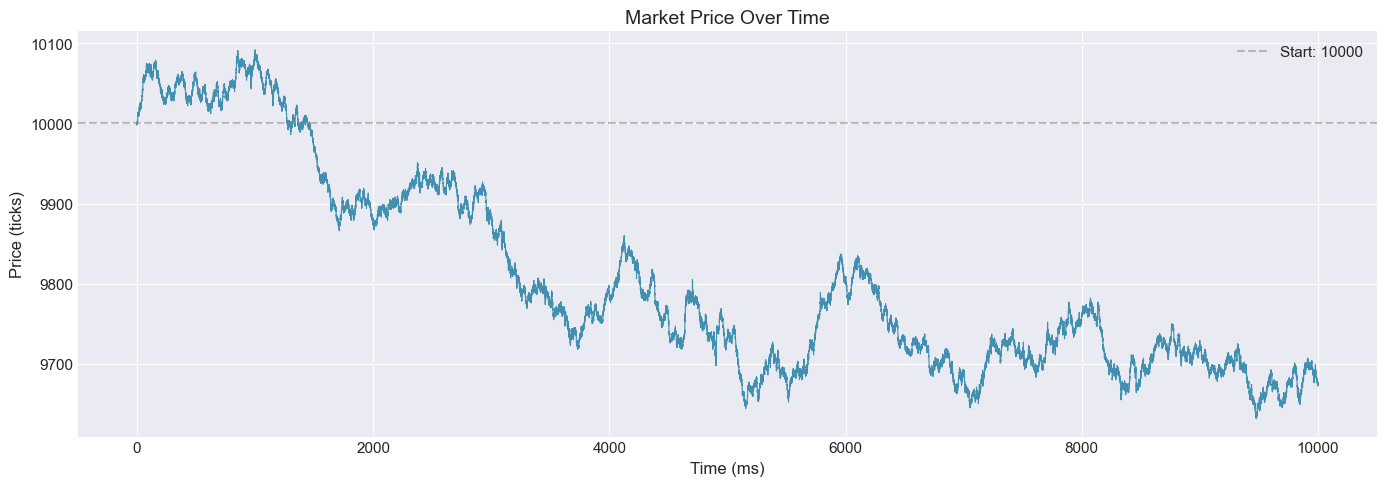

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(timestamps_ms, market_price, linewidth=0.8, color='#2E86AB', alpha=0.9)
ax.axhline(y=market_price[0], color='gray', linestyle='--', alpha=0.5, label=f'Start: {market_price[0]}')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Price (ticks)')
ax.set_title('Market Price Over Time')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 3. PnL Over Time (Total, Realized, Unrealized)

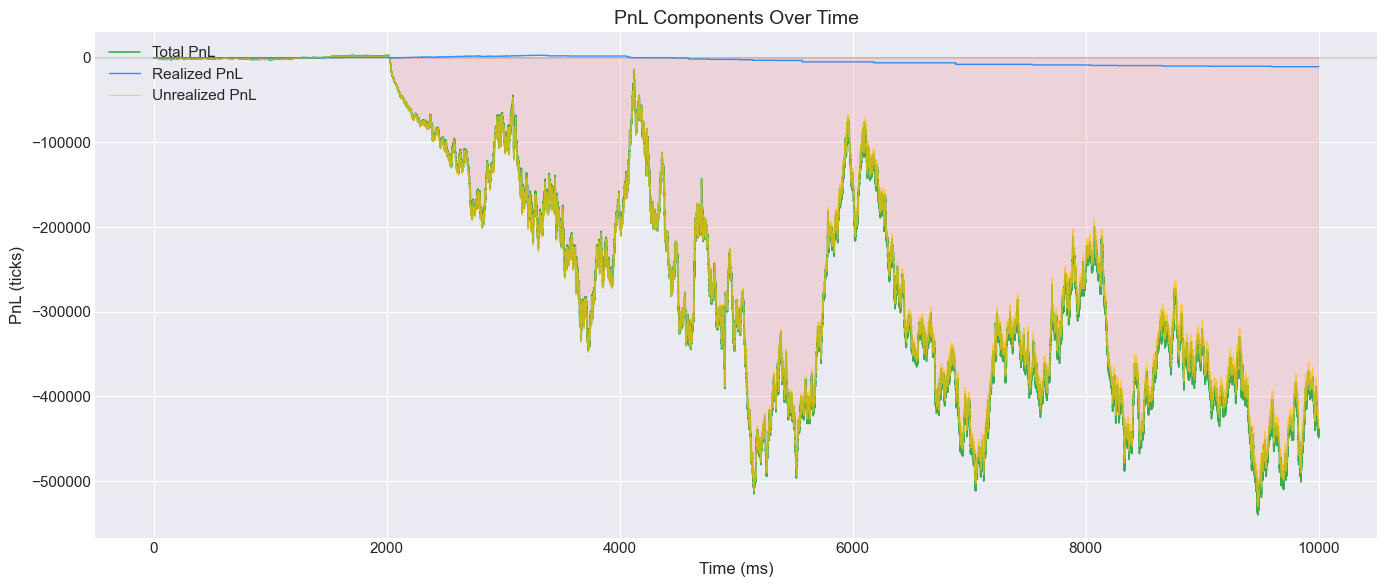

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(timestamps_ms, total_pnl, linewidth=1.2, color='#28A745', label='Total PnL', alpha=0.9)
ax.plot(timestamps_ms, realized_pnl, linewidth=1.0, color='#007BFF', label='Realized PnL', alpha=0.8)
ax.plot(timestamps_ms, unrealized_pnl, linewidth=0.8, color='#FFC107', label='Unrealized PnL', alpha=0.7)

ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.fill_between(timestamps_ms, total_pnl, 0, alpha=0.1, color='green', where=(total_pnl >= 0))
ax.fill_between(timestamps_ms, total_pnl, 0, alpha=0.1, color='red', where=(total_pnl < 0))

ax.set_xlabel('Time (ms)')
ax.set_ylabel('PnL (ticks)')
ax.set_title('PnL Components Over Time')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 4. Spread Over Time

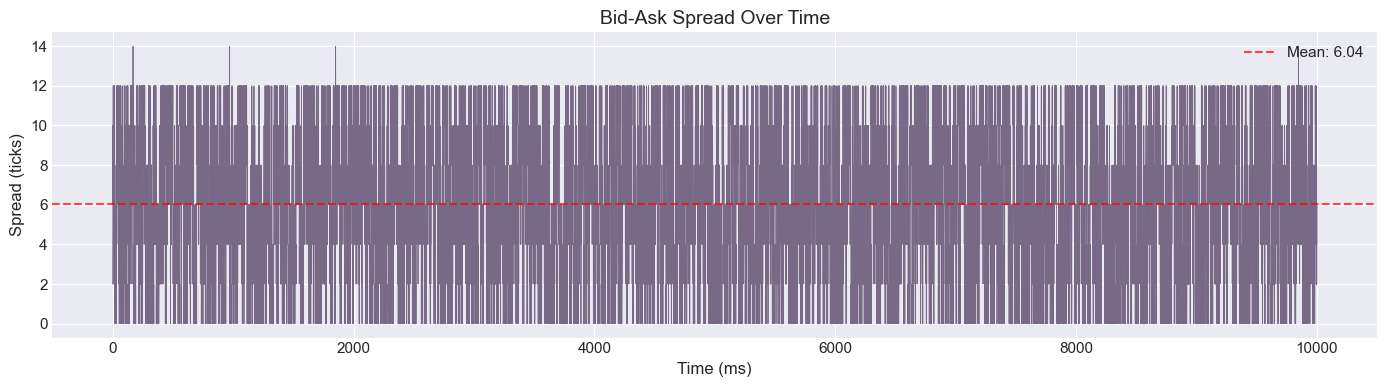

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(timestamps_ms, spread, linewidth=0.6, color='#6C5B7B', alpha=0.9)
ax.axhline(y=np.mean(spread), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(spread):.2f}')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spread (ticks)')
ax.set_title('Bid-Ask Spread Over Time')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 5. Returns Distribution

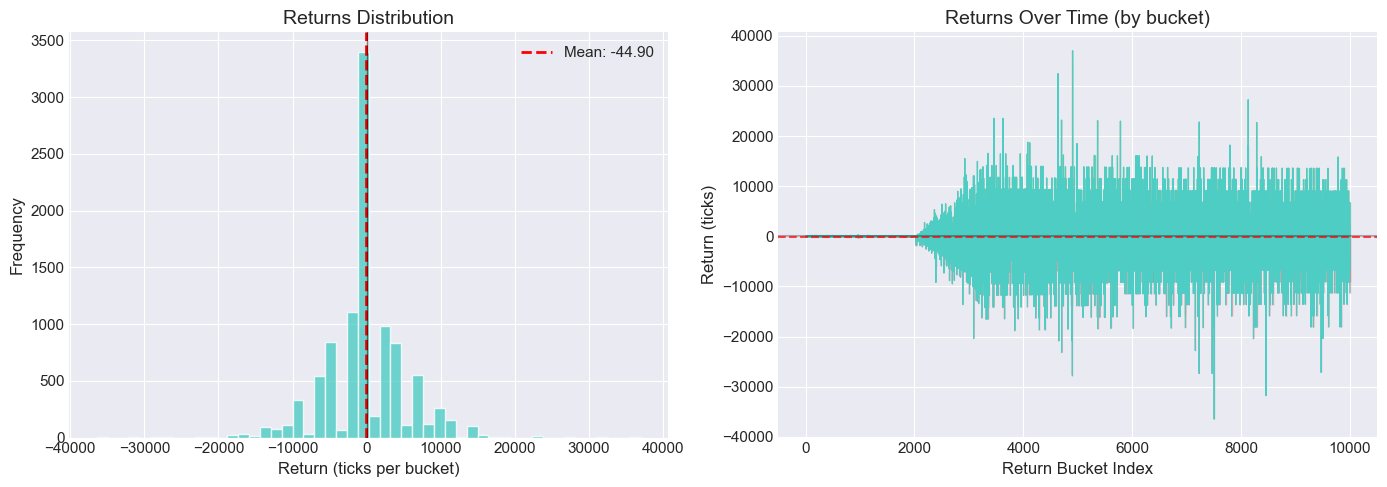

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
n_bins = min(50, len(returns) // 5 + 1)
ax1.hist(returns, bins=n_bins, color='#4ECDC4', edgecolor='white', alpha=0.8)
ax1.axvline(x=np.mean(returns), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(returns):.2f}')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_xlabel('Return (ticks per bucket)')
ax1.set_ylabel('Frequency')
ax1.set_title('Returns Distribution')
ax1.legend()

# Returns over time
ax2 = axes[1]
ax2.plot(returns, linewidth=0.8, color='#4ECDC4')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=np.mean(returns), color='red', linestyle='--', alpha=0.7)
ax2.fill_between(range(len(returns)), returns, 0, alpha=0.3, color='green', where=(np.array(returns) >= 0))
ax2.fill_between(range(len(returns)), returns, 0, alpha=0.3, color='red', where=(np.array(returns) < 0))
ax2.set_xlabel('Return Bucket Index')
ax2.set_ylabel('Return (ticks)')
ax2.set_title('Returns Over Time (by bucket)')

plt.tight_layout()
plt.show()

## 6. Cumulative Returns & Drawdown

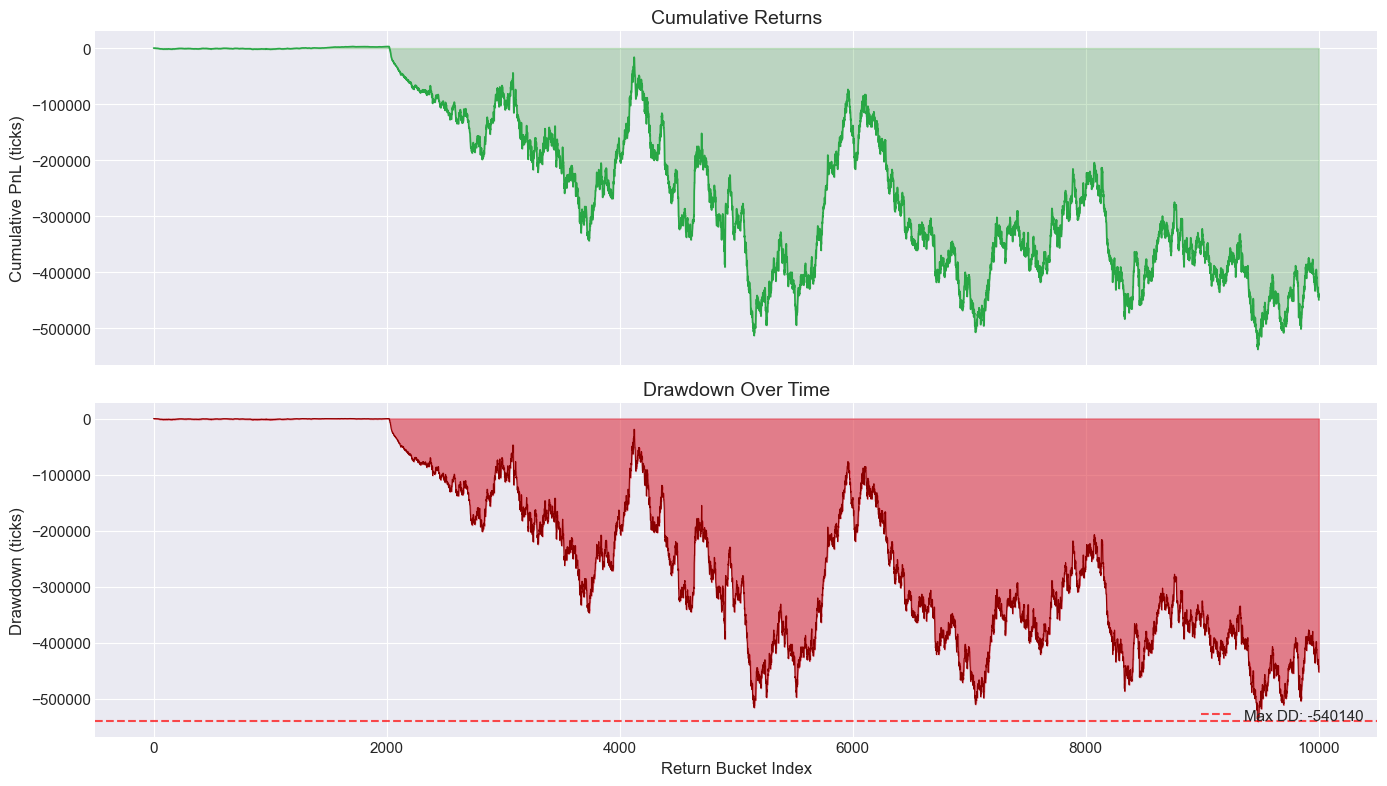

In [ ]:
cumulative_returns = np.cumsum(returns)
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - running_max

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Cumulative returns
ax1 = axes[0]
ax1.plot(cumulative_returns, linewidth=1.2, color='#28A745')
ax1.fill_between(range(len(cumulative_returns)), cumulative_returns, 0, alpha=0.2, color='green')
ax1.set_ylabel('Cumulative PnL (ticks)')
ax1.set_title('Cumulative Returns')

# Drawdown
ax2 = axes[1]
ax2.fill_between(range(len(drawdown)), drawdown, 0, color='#DC3545', alpha=0.6)
ax2.plot(drawdown, linewidth=0.8, color='#8B0000')
ax2.axhline(y=drawdown.min(), color='red', linestyle='--', alpha=0.7, label=f'Max DD: {drawdown.min():.0f}')
ax2.set_xlabel('Return Bucket Index')
ax2.set_ylabel('Drawdown (ticks)')
ax2.set_title('Drawdown Over Time')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

## 7. Equity Curve Analysis

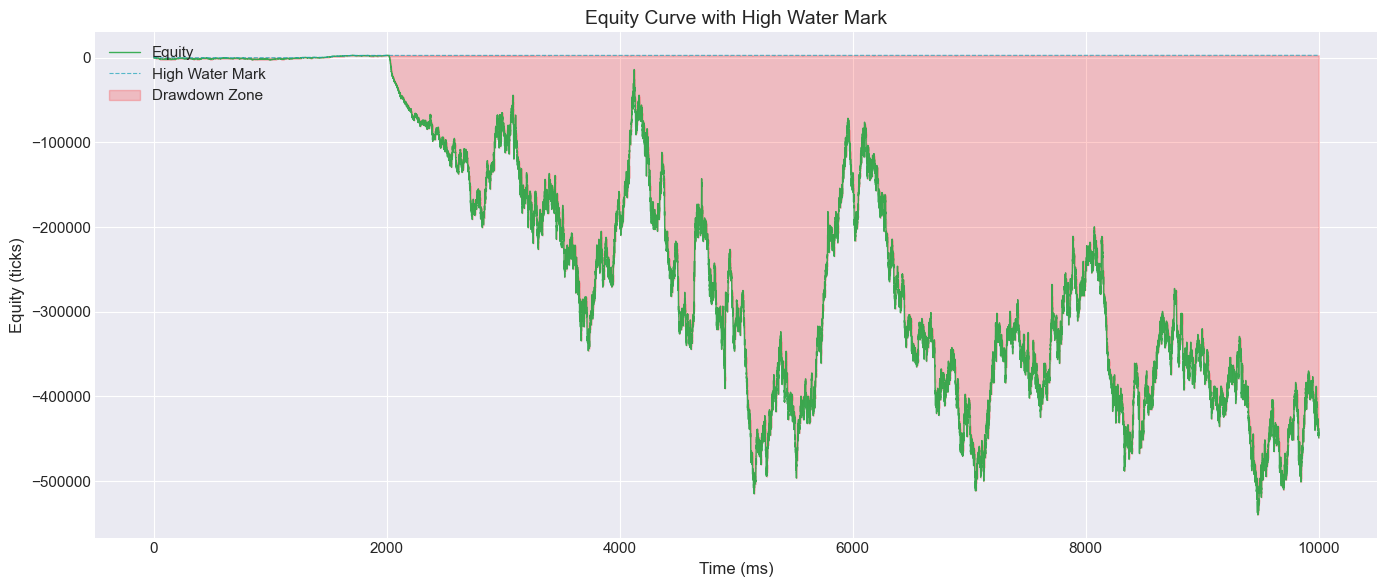

In [ ]:
# Peak equity tracking
equity_peak = np.maximum.accumulate(total_pnl)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(timestamps_ms, total_pnl, linewidth=1.0, color='#28A745', label='Equity', alpha=0.9)
ax.plot(timestamps_ms, equity_peak, linewidth=0.8, color='#17A2B8', linestyle='--', label='High Water Mark', alpha=0.7)
ax.fill_between(timestamps_ms, total_pnl, equity_peak, alpha=0.2, color='red', label='Drawdown Zone')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Equity (ticks)')
ax.set_title('Equity Curve with High Water Mark')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 8. Summary Dashboard

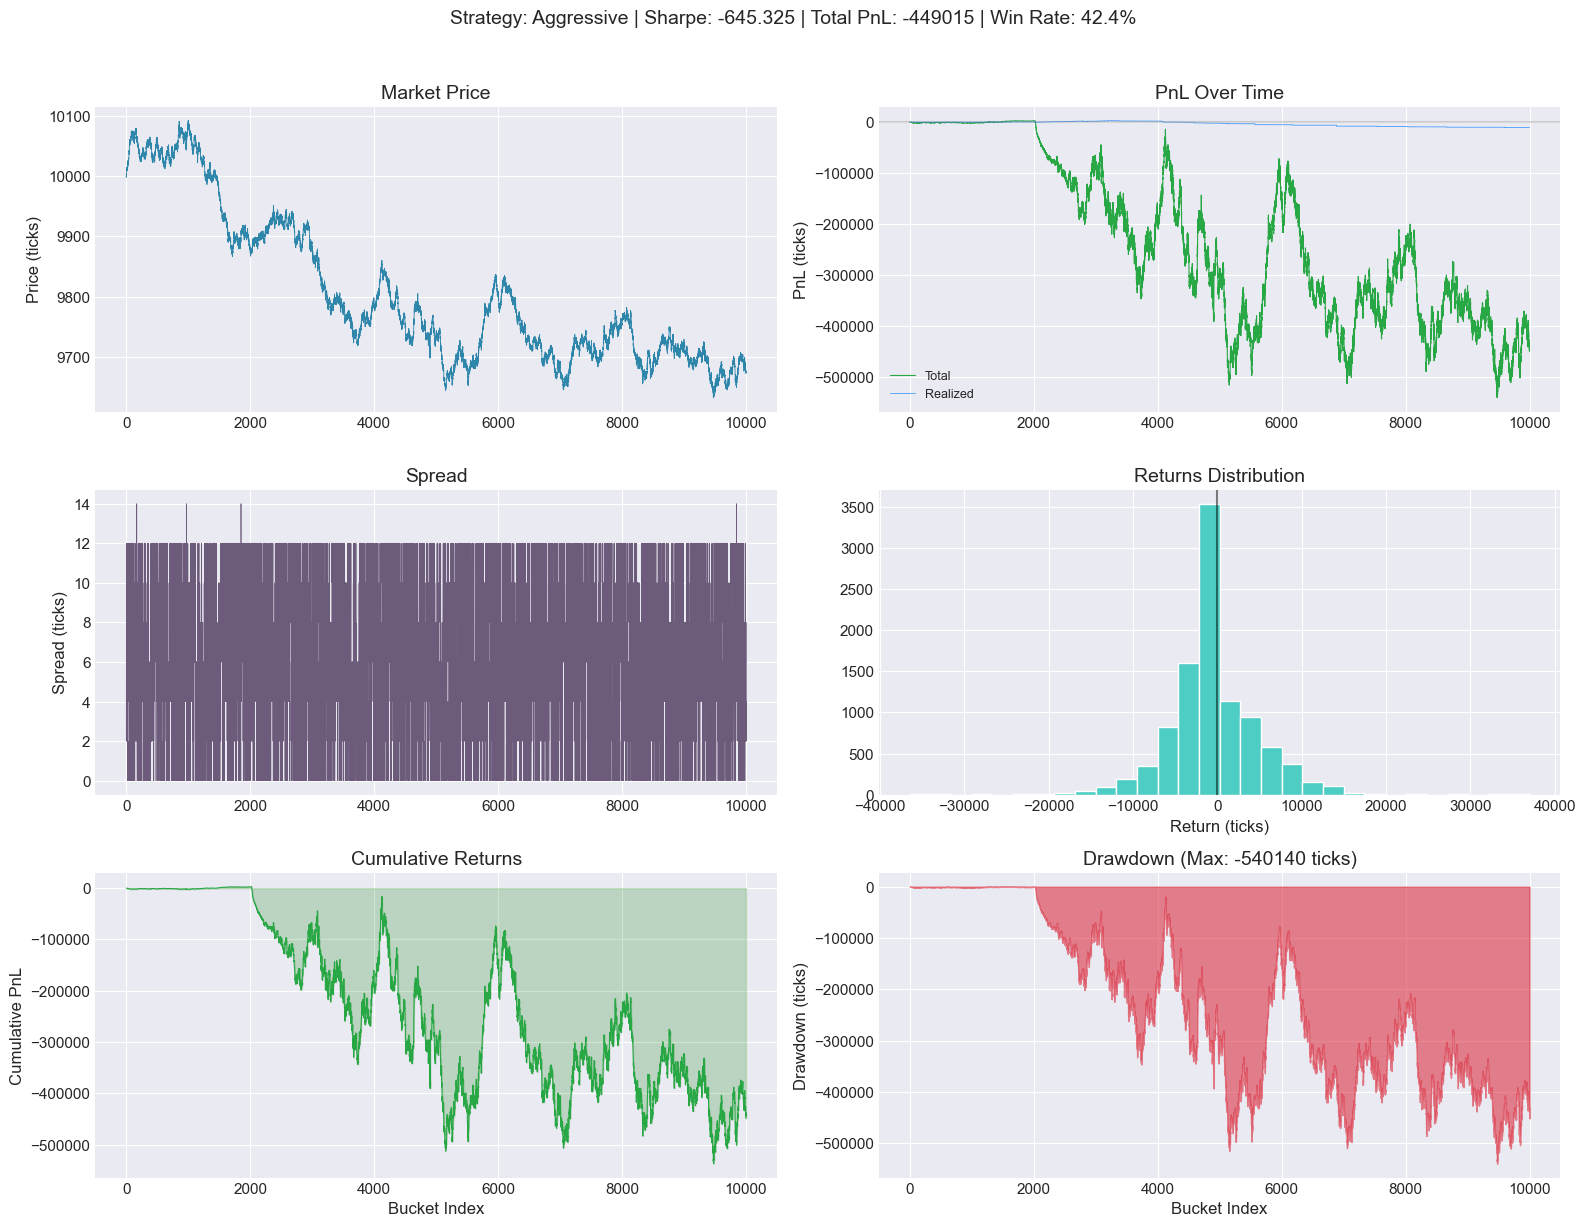

In [ ]:
fig = plt.figure(figsize=(16, 12))

# Market price
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(timestamps_ms, market_price, linewidth=0.6, color='#2E86AB')
ax1.set_title('Market Price')
ax1.set_ylabel('Price (ticks)')

# PnL
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(timestamps_ms, total_pnl, linewidth=0.8, color='#28A745', label='Total')
ax2.plot(timestamps_ms, realized_pnl, linewidth=0.6, color='#007BFF', alpha=0.7, label='Realized')
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.set_title('PnL Over Time')
ax2.set_ylabel('PnL (ticks)')
ax2.legend(fontsize=9)

# Spread
ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(timestamps_ms, spread, linewidth=0.5, color='#6C5B7B')
ax3.set_title('Spread')
ax3.set_ylabel('Spread (ticks)')

# Returns histogram
ax4 = fig.add_subplot(3, 2, 4)
ax4.hist(returns, bins=30, color='#4ECDC4', edgecolor='white')
ax4.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax4.set_title('Returns Distribution')
ax4.set_xlabel('Return (ticks)')

# Cumulative returns
ax5 = fig.add_subplot(3, 2, 5)
ax5.plot(cumulative_returns, linewidth=0.8, color='#28A745')
ax5.fill_between(range(len(cumulative_returns)), cumulative_returns, 0, alpha=0.2, color='green')
ax5.set_title('Cumulative Returns')
ax5.set_xlabel('Bucket Index')
ax5.set_ylabel('Cumulative PnL')

# Drawdown
ax6 = fig.add_subplot(3, 2, 6)
ax6.fill_between(range(len(drawdown)), drawdown, 0, color='#DC3545', alpha=0.6)
ax6.set_title(f'Drawdown (Max: {drawdown.min():.0f} ticks)')
ax6.set_xlabel('Bucket Index')
ax6.set_ylabel('Drawdown (ticks)')

plt.suptitle(f"Strategy: {strategy['name']} | Sharpe: {metrics.get_sharpe_ratio():.3f} | "
             f"Total PnL: {metrics.get_total_pnl_ticks()} | Win Rate: {metrics.get_win_rate():.1%}", 
             fontsize=14, y=1.02)

plt.tight_layout()
plt.show()

## 9. Performance Metrics Table

In [ ]:
# Create a summary table
from IPython.display import display, HTML

metrics_data = {
    "PnL Metrics": {
        "Total PnL (ticks)": metrics.get_total_pnl_ticks(),
        "Realized PnL (ticks)": metrics.get_realized_pnl_ticks(),
        "Unrealized PnL (ticks)": metrics.get_unrealized_pnl_ticks(),
        "Fees Paid (ticks)": metrics.fees_ticks,
    },
    "Risk Metrics": {
        "Sharpe Ratio": f"{metrics.get_sharpe_ratio():.4f}",
        "Max Drawdown (ticks)": metrics.get_max_drawdown_ticks(),
        "Volatility": f"{metrics.get_volatility():.4f}",
    },
    "Performance Metrics": {
        "Win Rate": f"{metrics.get_win_rate():.2%}",
        "Profit Factor": f"{metrics.get_profit_factor():.4f}",
        "Gross Profit": f"{metrics.get_gross_profit():.2f}",
        "Gross Loss": f"{metrics.get_gross_loss():.2f}",
    },
    "Trading Activity": {
        "Final Position": metrics.get_position(),
        "Gross Traded Qty": metrics.get_gross_traded_qty(),
        "Fill Ratio": f"{metrics.get_fill_ratio():.2%}",
        "Total Slippage (ticks)": metrics.total_slippage_ticks,
    },
    "Order Statistics": {
        "Resting Attempted": metrics.resting_attempted_qty,
        "Resting Filled": metrics.resting_filled_qty,
        "Resting Cancelled": metrics.resting_cancelled_qty,
    },
}

html = f"<h3>Performance Summary: {strategy['name']}</h3>"
for category, values in metrics_data.items():
    html += f"<h4>{category}</h4><table border='1' style='border-collapse: collapse; margin: 10px 0;'>"
    for key, val in values.items():
        html += f"<tr><td style='padding: 8px; font-weight: bold;'>{key}</td><td style='padding: 8px; text-align: right;'>{val}</td></tr>"
    html += "</table>"

display(HTML(html))

: 

## 10. Strategy Comparison

In [ ]:
# Run all strategies and compare
results = {}
all_pnl_series = {}

for name, strat in STRATEGIES.items():
    print(f"Running {strat['name']}...")
    m = run_simulation(strategy_config=strat, sim_config=sim_config, verbose=False)
    results[strat['name']] = m
    all_pnl_series[strat['name']] = np.array(m.total_pnl_ticks_series)

print("\n✓ All simulations complete")

Running Aggressive...
Running Balanced...
Running Passive...

✓ All simulations complete


: 

: 

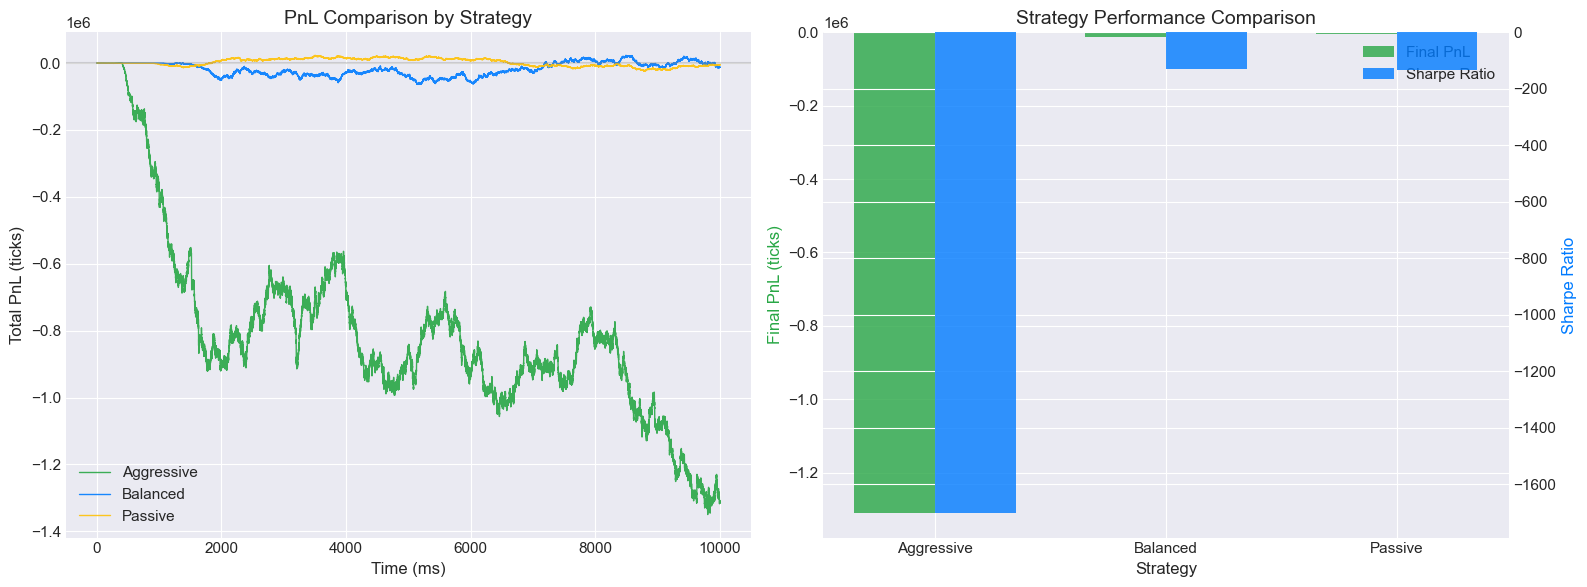

In [ ]:
# Plot PnL comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#28A745', '#007BFF', '#FFC107', '#DC3545', '#6C5B7B']

# PnL over time
ax1 = axes[0]
for i, (name, pnl) in enumerate(all_pnl_series.items()):
    ts_local = np.array(results[name].timestamp_series) / 1000
    ax1.plot(ts_local, pnl, linewidth=1.0, color=colors[i % len(colors)], label=name, alpha=0.9)

ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Total PnL (ticks)')
ax1.set_title('PnL Comparison by Strategy')
ax1.legend()

# Bar chart comparison
ax2 = axes[1]
strategy_names = list(results.keys())
final_pnl = [results[n].get_total_pnl_ticks() for n in strategy_names]
sharpe = [results[n].get_sharpe_ratio() for n in strategy_names]

x = np.arange(len(strategy_names))
width = 0.35

bars1 = ax2.bar(x - width/2, final_pnl, width, label='Final PnL', color=colors[0], alpha=0.8)
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, sharpe, width, label='Sharpe Ratio', color=colors[1], alpha=0.8)

ax2.set_xlabel('Strategy')
ax2.set_ylabel('Final PnL (ticks)', color=colors[0])
ax2_twin.set_ylabel('Sharpe Ratio', color=colors[1])
ax2.set_title('Strategy Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(strategy_names)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Combined legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Comparison table
comparison_metrics = [
    ("Total PnL", lambda m: m.get_total_pnl_ticks()),
    ("Realized PnL", lambda m: m.get_realized_pnl_ticks()),
    ("Sharpe Ratio", lambda m: f"{m.get_sharpe_ratio():.4f}"),
    ("Max Drawdown", lambda m: m.get_max_drawdown_ticks()),
    ("Win Rate", lambda m: f"{m.get_win_rate():.2%}"),
    ("Profit Factor", lambda m: f"{m.get_profit_factor():.4f}"),
    ("Fill Ratio", lambda m: f"{m.get_fill_ratio():.2%}"),
    ("Gross Traded Qty", lambda m: m.get_gross_traded_qty()),
    ("Fees Paid", lambda m: m.fees_ticks),
]

html = "<h3>Strategy Comparison Table</h3>"
html += "<table border='1' style='border-collapse: collapse; width: 100%;'>"
html += "<tr><th style='padding: 10px;'>Metric</th>"
for name in results.keys():
    html += f"<th style='padding: 10px;'>{name}</th>"
html += "</tr>"

for metric_name, getter in comparison_metrics:
    html += f"<tr><td style='padding: 8px; font-weight: bold;'>{metric_name}</td>"
    for m in results.values():
        val = getter(m)
        html += f"<td style='padding: 8px; text-align: right;'>{val}</td>"
    html += "</tr>"

html += "</table>"
display(HTML(html))

Metric,Aggressive,Balanced,Passive
Total PnL,-1311202,-12518,-5274
Realized PnL,-68262,-5082,-1134
Sharpe Ratio,-1704.2301,-128.1395,-133.3280
Max Drawdown,-1350785,-64478,-46368
Win Rate,41.73%,42.73%,42.82%
Profit Factor,0.9432,0.9954,0.9953
Fill Ratio,2.79%,2.77%,6.64%
Gross Traded Qty,2573,414,173
Fees Paid,-5146,-828,-346
